# Importing the platframes

In [1071]:
import pandas as pd
import numpy as np

# Reading the dataset

In [1072]:
dataset = pd.read_csv('framingham.csv')

# Checking the null values 

In [1073]:
# Checking missing values
# Any missing values?
print(dataset.isnull().values.any())
# Sum of missing values in different columns
print(dataset.isnull().sum())

True
male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64


In [1074]:
dataset.head(10)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
5,0,43,2.0,0,0.0,0.0,0,1,0,228.0,180.0,110.0,30.30,77.0,99.0,0
6,0,63,1.0,0,0.0,0.0,0,0,0,205.0,138.0,71.0,33.11,60.0,85.0,1
7,0,45,2.0,1,20.0,0.0,0,0,0,313.0,100.0,71.0,21.68,79.0,78.0,0
8,1,52,1.0,0,0.0,0.0,0,1,0,260.0,141.5,89.0,26.36,76.0,79.0,0
9,1,43,1.0,1,30.0,0.0,0,1,0,225.0,162.0,107.0,23.61,93.0,88.0,0


# Dealing with null values 

In [1075]:
# Dropping columns and importing again
dataset = dataset.drop(dataset.columns[[5,6]], axis=1)
y=dataset["TenYearCHD"]
x=dataset.drop(["TenYearCHD"],axis=1)

In [1076]:
# Replacing the missing data
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(dataset)
dataset = imputer.transform(dataset)


In [1077]:
# Replacing the missing data again after dropping columns
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(x)
x = imputer.transform(x)

# Feature Scaling

In [1078]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x = sc.fit_transform(x)

# Feature Selection using PCA

In [1079]:
# Feature Selection
# Applying Principal Component Analysis
from sklearn.decomposition import PCA
n_components=4
pca = PCA(n_components=n_components)
x = pca.fit_transform(x)
x.shape

(4238, 4)

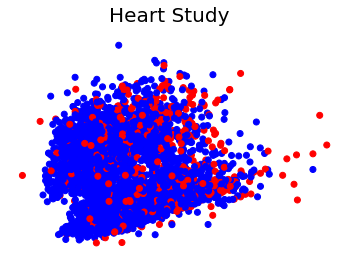

In [1080]:
import matplotlib.pyplot as plt
c = ["blue" if y_ == 0 else "red" for y_ in y]  # colours for each class
plt.axis("off")
plt.suptitle('Heart Study', fontsize=20)
plt.scatter(x[:, 0], x[:, 1], c=c)
plt.show()

# Splitting by taking a sample

In [1081]:
# Splitting the data set into training set and test set
from sklearn.model_selection import train_test_split
train_size=60
test_size=12
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=train_size,test_size=test_size, random_state=666)

In [1082]:
from sklearn.preprocessing import MinMaxScaler
# scale after pca  
scaler = MinMaxScaler((-1,1))
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)
#Scale  after pca 
xtrain = sc.fit_transform(xtrain)
xtest = sc.transform(xtest)

# Build the Hybird Q Neural network penny lane

In [1083]:
weight_specs = {"weights": {"initializer": "random_uniform"}}

In [1084]:
import pennylane as qml
import tensorflow as tf
from keras.regularizers import l2
n_qubits =4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0)),qml.expval(qml.PauliZ(1))

weight_shapes = {"weights": (3, n_qubits,3)}


In [1085]:
# sequential model to initialise our ann and dense module to build the layers
from keras.models import Sequential
from keras.layers import Dense,Dropout 


qlayer1 = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=2)
qlayer2= qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=2)
clayer1 = tf.keras.layers.Dense(4,kernel_initializer= "uniform", bias_initializer= 
   "zeros")
clayer4=Dropout(0.5)
clayer2= tf.keras.layers.Dense(2)
clayer3 = tf.keras.layers.Dense(1,activation="sigmoid")
model = tf.keras.models.Sequential([clayer1,clayer2,clayer4, qlayer1,qlayer2, clayer3])

In [1086]:
from tensorflow import keras
initial_learning_rate = 0.5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(opt,  metrics=["acc"],loss='mse')# instead of binary_classification  to avoid Overfitting


In [1087]:
history=model.fit(xtrain,ytrain, epochs=10,batch_size=5)

Epoch 1/10
12/12 [==============================] - 8s 633ms/step - loss: 0.2560 - acc: 0.6186
Epoch 2/10
12/12 [==============================] - 8s 637ms/step - loss: 0.1366 - acc: 0.8520
Epoch 3/10
12/12 [==============================] - 8s 636ms/step - loss: 0.0943 - acc: 0.8938
Epoch 4/10
12/12 [==============================] - 8s 633ms/step - loss: 0.1513 - acc: 0.8428
Epoch 5/10
12/12 [==============================] - 8s 636ms/step - loss: 0.1083 - acc: 0.8832
Epoch 6/10
12/12 [==============================] - 8s 636ms/step - loss: 0.0721 - acc: 0.9252
Epoch 7/10
12/12 [==============================] - 8s 639ms/step - loss: 0.0766 - acc: 0.9129
Epoch 8/10
12/12 [==============================] - 8s 646ms/step - loss: 0.1706 - acc: 0.7946
Epoch 9/10
12/12 [==============================] - 8s 637ms/step - loss: 0.0741 - acc: 0.9187
Epoch 10/10
12/12 [==============================] - 8s 639ms/step - loss: 0.1092 - acc: 0.8742


In [1088]:

score1 = model.evaluate(xtrain, ytrain)
print("Training loss:", score1[0])
print("Training accuracy:", score1[1])

2/2 [==============================] - 3s 1s/step - loss: 0.1175 - acc: 0.8667
Training loss: 0.11746092140674591
Training accuracy: 0.8666666746139526


In [1089]:
score2 = model.evaluate(xtest, ytest)
print("Test loss:", score2[0])
print("Test accuracy:", score2[1])


1/1 [==============================] - 1s 553ms/step - loss: 0.1397 - acc: 0.8333
Test loss: 0.13966871798038483
Test accuracy: 0.8333333134651184
